# Scraping Safety Data - City of Toronto Police

Because this is GEOJSON data, I could not use Beautifulsoup4. So, the processes below is really to import and convert to a pandas dataframe. Then, I can explore these data.

In [5]:
import osmnx  # to import and manage road netwrok data
import geopandas  # needed get background data
import requests  # for making standard html requests
import pandas  # premier library for data organization
import numpy  # for data manipulation
import rasterstats # to interpolate raster data
from random import shuffle # for managing psedoabsences

URL_Robbery = 'https://opendata.arcgis.com/datasets/9115accc55f24938b4eb573dd222c33b_0.geojson'
URL_Pedestrian = 'https://opendata.arcgis.com/datasets/1e8a71c533fb4b0aa522cf1b1236bee7_0.geojson'
page_robbery = requests.get(URL_Robbery).json()
page_pedestrian = requests.get(URL_Pedestrian).json()

pedestrian_json_df = pandas.json_normalize(page_pedestrian['features'])
robbery_json_df = pandas.json_normalize(page_robbery['features'])  

Interested in the number of features and which columns I should keep.

In [6]:
list(pedestrian_json_df)

['type',
 'properties.Index_',
 'properties.ACCNUM',
 'properties.YEAR',
 'properties.DATE',
 'properties.TIME',
 'properties.HOUR',
 'properties.STREET1',
 'properties.STREET2',
 'properties.OFFSET',
 'properties.ROAD_CLASS',
 'properties.District',
 'properties.WardNum',
 'properties.Division',
 'properties.LATITUDE',
 'properties.LONGITUDE',
 'properties.LOCCOORD',
 'properties.ACCLOC',
 'properties.TRAFFCTL',
 'properties.VISIBILITY',
 'properties.LIGHT',
 'properties.RDSFCOND',
 'properties.ACCLASS',
 'properties.IMPACTYPE',
 'properties.INVTYPE',
 'properties.INVAGE',
 'properties.INJURY',
 'properties.FATAL_NO',
 'properties.INITDIR',
 'properties.VEHTYPE',
 'properties.MANOEUVER',
 'properties.DRIVACT',
 'properties.DRIVCOND',
 'properties.PEDTYPE',
 'properties.PEDACT',
 'properties.PEDCOND',
 'properties.CYCLISTYPE',
 'properties.CYCACT',
 'properties.CYCCOND',
 'properties.PEDESTRIAN',
 'properties.CYCLIST',
 'properties.AUTOMOBILE',
 'properties.MOTORCYCLE',
 'properties.TR

In [7]:
len(pedestrian_json_df)

6484

In [8]:
list(robbery_json_df)

['type',
 'properties.Index_',
 'properties.event_unique_id',
 'properties.occurrencedate',
 'properties.reporteddate',
 'properties.premisetype',
 'properties.ucr_code',
 'properties.ucr_ext',
 'properties.offence',
 'properties.reportedyear',
 'properties.reportedmonth',
 'properties.reportedday',
 'properties.reporteddayofyear',
 'properties.reporteddayofweek',
 'properties.reportedhour',
 'properties.occurrenceyear',
 'properties.occurrencemonth',
 'properties.occurrenceday',
 'properties.occurrencedayofyear',
 'properties.occurrencedayofweek',
 'properties.occurrencehour',
 'properties.MCI',
 'properties.Division',
 'properties.Hood_ID',
 'properties.Neighbourhood',
 'properties.Long',
 'properties.Lat',
 'properties.ObjectId',
 'geometry.type',
 'geometry.coordinates']

In [9]:
len(robbery_json_df)

21543

Strange, but each column has a properties. prefix. Looks weird, so I am going to remove it

In [10]:
pedestrian_json_df.columns = pedestrian_json_df.columns.str.lstrip('properties.')
robbery_json_df.columns = robbery_json_df.columns.str.lstrip('properties.')

Focusing on features that I believe are predictive.

In [19]:
pedestrian_df = pedestrian_json_df.iloc[:, numpy.r_[3,5,6, 10, 14,15, 19, 20,52]]
pedestrian_df

,YEAR,TIME,HOUR,ROAD_CLASS,LATITUDE,LONGITUDE,VISIBILITY,LIGHT,Hood_ID
0,2006,705,7,Major Arterial,43.652892,-79.406253,Other,"Dark, artificial",78
1,2006,705,7,Major Arterial,43.652892,-79.406253,Other,"Dark, artificial",78
2,2006,1940,19,Major Arterial,43.655145,-79.433590,Rain,Dark,83
3,2006,1940,19,Major Arterial,43.655145,-79.433590,Rain,Dark,83
4,2006,2210,22,Major Arterial,43.777056,-79.347858,Clear,"Dark, artificial",47
...,...,...,...,...,...,...,...,...,...
6479,2019,2002,20,Major Arterial,43.765876,-79.270527,Clear,Daylight,127
6480,2019,2002,20,Major Arterial,43.765876,-79.270527,Clear,Daylight,127
6481,2019,902,9,Major Arterial,43.652610,-79.378055,Clear,Daylight,75
6482,2019,902,9,Major Arterial,43.652610,-79.378055,Clear,Daylight,75


In [20]:
robbery_df = robbery_json_df.iloc[:, numpy.r_[1:3, 9, 10, 11, 12, 13, 14, 5, 8, 22, 23, 25, 26]]
robbery_df

,Index_,vent_unique_id,dyear,dmonth,dday,ddayofyear,ddayofweek,dhour,misetype,ffence,Division,Hood_ID,Long,Lat
0,1,GO-20141289469,2014,January,6,6,Monday,1,Other,Robbery - Mugging,D31,27,-79.503388,43.769791
1,609,GO-20142439653,2014,July,6,187,Sunday,1,Outside,Robbery - Taxi,D51,75,-79.371910,43.650467
2,4,GO-20141331950,2014,January,12,12,Sunday,20,Other,Robbery With Weapon,D42,130,-79.300468,43.808918
3,610,GO-20142440272,2014,July,6,187,Sunday,3,Outside,Robbery - Mugging,D43,139,-79.217850,43.740662
4,5,GO-20141331950,2014,January,12,12,Sunday,20,Other,Robbery With Weapon,D42,130,-79.300468,43.808918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21538,194136,GO-20182197844,2018,November,29,333,Thursday,20,Outside,Robbery - Other,D23,5,-79.551002,43.723167
21539,194141,GO-20182269351,2018,December,11,345,Tuesday,1,Apartment,Robbery - Home Invasion,D51,72,-79.358688,43.662418
21540,194142,GO-20182269351,2018,December,11,345,Tuesday,1,Apartment,Robbery - Home Invasion,D51,72,-79.358688,43.662418
21541,194143,GO-20182269351,2018,December,11,345,Tuesday,1,Apartment,Robbery - Home Invasion,D51,72,-79.358688,43.662418


I will subset the data. For the robbery data, I only want the mugging data because this is most applicable for pedestrians

In [81]:
robbery_df_mugging = robbery_df.loc[robbery_df['ffence'] == 'Robbery - Mugging']  # 6847 rows
robbery_df_mugging_outside = robbery_df_mugging.loc[robbery_df_mugging['misetype'] == 'Outside']  # 5141 rows
robbery_df_mugging_outside

,Index_,vent_unique_id,dyear,dmonth,dday,ddayofyear,ddayofweek,dhour,misetype,ffence,Division,Hood_ID,Long,Lat
3,610,GO-20142440272,2014,July,6,187,Sunday,3,Outside,Robbery - Mugging,D43,139,-79.217850,43.740662
5,614,GO-20142444068,2014,July,6,187,Sunday,19,Outside,Robbery - Mugging,D22,18,-79.504143,43.601009
6,9,GO-20141332202,2014,January,12,12,Sunday,22,Outside,Robbery - Mugging,D51,76,-79.382118,43.659100
7,639,GO-20142117825,2014,May,20,140,Tuesday,19,Outside,Robbery - Mugging,D54,58,-79.348290,43.696964
9,640,GO-20142117825,2014,May,20,140,Tuesday,19,Outside,Robbery - Mugging,D54,58,-79.348290,43.696964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21494,193808,GO-20192121296,2019,November,2,306,Saturday,23,Outside,Robbery - Mugging,D33,42,-79.339500,43.728607
21498,193848,GO-20181659688,2018,September,7,250,Friday,17,Outside,Robbery - Mugging,D31,25,-79.510452,43.749229
21503,193886,GO-20182208408,2018,December,1,335,Saturday,12,Outside,Robbery - Mugging,D42,116,-79.322540,43.816147
21516,194015,GO-20181990705,2018,October,28,301,Sunday,17,Outside,Robbery - Mugging,D43,137,-79.233078,43.758186


Some features are unbalanced. I will remove accident locations with few observations (<10)


In [82]:
pedestrian_df_road = pedestrian_df.loc[pedestrian_df['ROAD_CLASS'].isin(['Major Arterial', 'Minor Arterial',
                                                                         'Collector', 'Local',
                                                                         'Expressway'])]  # 4986 rows

I will need to create geaodataframes many times, so a function will be best to make the code cleaner.

In [23]:
def create_gdf(df, Longitude, Latitude, projection):
    return geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df[Longitude], df[Latitude]),
                                  crs=projection)

Need as spatial data to measure distance to features later.

In [83]:
robbery_points_gdf_2958 = create_gdf(df=robbery_df_mugging_outside,
                                     Latitude="Lat",
                                     Longitude="Long",
                                     projection="EPSG:4326")

robbery_points_gdf_4326 = create_gdf(df=robbery_df_mugging_outside,
                                     Latitude="Lat",
                                     Longitude="Long",
                                     projection="EPSG:4326")
robbery_points_gdf_2958 = robbery_points_gdf_2958.to_crs(epsg = 2958) 
pedestrian_points_gdf_2958 = create_gdf(df=pedestrian_df_road,
                                     Latitude="LATITUDE",
                                     Longitude="LONGITUDE",
                                     projection="EPSG:4326")

pedestrian_points_gdf_4326 = create_gdf(df=pedestrian_df_road,
                                        Latitude="LATITUDE",
                                        Longitude="LONGITUDE",
                                     projection="EPSG:4326")
pedestrian_points_gdf_2958 = pedestrian_points_gdf_2958.to_crs(epsg = 2958)  

Need consistency in labelling for future analyses

In [3]:
# Importing background points I generated in ArcMap
backgroundpoints = geopandas.read_file('C:/Users/jodyn/Google Drive/Insight Data Science/Insight/Terrain/Toronto_Roads_Background_2958.shp')

In [61]:
# need to randomly select the same number of backgrounds point as in my data  
robbery_backgroundpoints = backgroundpoints.sample(n=len(robbery_points_gdf_2958))
robbery_backgroundpoints['Latitude'] = list(robbery_backgroundpoints['geometry'].y)
robbery_backgroundpoints['Longitude'] = list(robbery_backgroundpoints['geometry'].x)
pedestrian_backgroundpoints = backgroundpoints.sample(n=len(pedestrian_points_gdf_2958))
pedestrian_backgroundpoints['Latitude'] = list(pedestrian_backgroundpoints['geometry'].y)
pedestrian_backgroundpoints['Longitude'] = list(pedestrian_backgroundpoints['geometry'].x)


In [80]:
# need to make sure that the projections are correct for when I generate the distances to other features
robbery_backgroundpoints_gdf_2958 =  create_gdf(df=robbery_backgroundpoints,
                                               Latitude="Latitude",
                                               Longitude="Longitude",
                                               projection="EPSG:2958")

robbery_backgroundpoints_gdf_4326 = robbery_backgroundpoints_2958.to_crs(epsg = 4326)
robbery_backgroundpoints_gdf_4326 = robbery_backgroundpoints_gdf_4326.drop(['Latitude', 'Longitude'], axis = 1)
robbery_backgroundpoints_gdf_4326['Latitude'] = list(robbery_backgroundpoints_gdf_4326['geometry'].y)
robbery_backgroundpoints_gdf_4326['Longitude'] = list(robbery_backgroundpoints_gdf_4326['geometry'].x)

pedestrian_backgroundpoints_gdf_2958 =  create_gdf(df=pedestrian_backgroundpoints,
                                               Latitude="Latitude",
                                               Longitude="Longitude",
                                               projection="EPSG:2958")
pedestrian_backgroundpoints_gdf_4326 = pedestrian_backgroundpoints_2958.to_crs(epsg = 4326)
pedestrian_backgroundpoints_gdf_4326 = pedestrian_backgroundpoints_gdf_4326.drop(['Latitude', 'Longitude'], axis = 1)
pedestrian_backgroundpoints_gdf_4326['Latitude'] = list(pedestrian_backgroundpoints_gdf_4326['geometry'].y)
pedestrian_backgroundpoints_gdf_4326['Longitude'] = list(pedestrian_backgroundpoints_gdf_4326['geometry'].x)


In [41]:
# I want consistency in the lat/long names for later measures
robbery_points_gdf_2958 = robbery_points_gdf_2958.rename(columns={"Long": "Longitude", "Lat": "Latitude"})
robbery_points_gdf_4326 = robbery_points_gdf_4326.rename(columns={"Long": "Longitude", "Lat": "Latitude"})
pedestrian_points_gdf_2958 = pedestrian_points_gdf_2958.rename(columns={"LONGITUDE": "Longitude", "LATITUDE": "Latitude"})
pedestrian_points_gdf_4326 = pedestrian_points_gdf_4326.rename(columns={"LONGITUDE": "Longitude", "LATITUDE": "Latitude"})


It will be easier to re-run making the psedoabsences if I make a function considering that I might extend to the GTA and not just Old Toronto.

In [85]:
special = list(set(list(robbery_points_gdf_4326)) - set(list(robbery_backgroundpoints_gdf_4326)))
for i in special:
    longer = list(robbery_points_gdf_4326[i].unique())
    call = numpy.repeat(longer,
                        len(robbery_backgroundpoints_gdf_4326) / len(longer) * 2)
    shuffle(call)
    robbery_backgroundpoints_gdf_4326[i] = call[0:len(robbery_backgroundpoints_gdf_4326)]

robbery_points_gdf_4326['Presence_Absence'] = numpy.repeat(1,
                                                           len(robbery_points_gdf_4326))
robbery_backgroundpoints_gdf_4326['Presence_Absence'] = numpy.repeat(0,
                                                                     len(robbery_backgroundpoints_gdf_4326))

special = list(set(list(pedestrian_points_gdf_4326)) - set(list(pedestrian_backgroundpoints_gdf_4326)))
for i in special:
    longer = list(pedestrian_points_gdf_4326[i].unique())
    call = numpy.repeat(longer,
                        len(pedestrian_backgroundpoints_gdf_4326) / len(longer) * 2)
    shuffle(call)
    pedestrian_backgroundpoints_gdf_4326[i] = call[0:len(pedestrian_backgroundpoints_gdf_4326)]

pedestrian_points_gdf_4326['Presence_Absence'] = numpy.repeat(1,
                                                           len(pedestrian_points_gdf_4326))
pedestrian_backgroundpoints_gdf_4326['Presence_Absence'] = numpy.repeat(0,
                                                                     len(pedestrian_backgroundpoints_gdf_4326))

In [86]:
# now we can combine both data sets and
robbery_model_data = robbery_points_gdf_4326.append(
    pandas.DataFrame(data=robbery_backgroundpoints_gdf_4326),
    ignore_index=True)
robbery_model_data_final = robbery_model_data.iloc[:, numpy.r_[0, 2:len(list(robbery_model_data))]]
robbery_model_data_final.Presence_Absence.value_counts()

1    5141
0    5141
Name: Presence_Absence, dtype: int64

Importing location Data to Measure Proximity transporation data to later measure distance to feature for regression/random forest need a UTM projection for distance to feature.


In [87]:
pedestrian_model_data = pedestrian_points_gdf_4326.append(
    pandas.DataFrame(data=pedestrian_backgroundpoints_gdf_4326),
    ignore_index=True)
pedestrian_model_data_final = pedestrian_model_data.iloc[:, numpy.r_[0, 2:len(list(pedestrian_model_data))]]
pedestrian_model_data_final.Presence_Absence.value_counts()

1    6433
0    6433
Name: Presence_Absence, dtype: int64

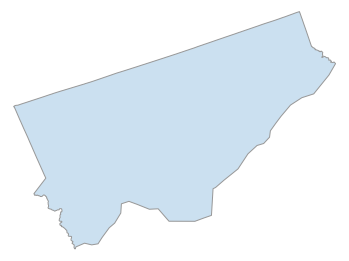

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a4ef4e9e88>)

In [42]:
place_name = 'City of Toronto'
place_shape = osmnx.gdf_from_place(place_name)
osmnx.plot_shape(osmnx.projection.project_gdf(place_shape))

In [43]:
selected_tags = {'highway': True}
stations_OldToronto = osmnx.pois_from_place(place = place_name, tags = selected_tags)

Dropping some fetaures that I do not need some of them are polygons.

In [44]:
features_location_names = ['crossing', 'give_way', 'stop', 'traffic_signals', 'turning_loop', 'speed_camera']
stations_OldToronto_4326 = stations_OldToronto[stations_OldToronto.highway.isin(features_location_names)]
stations_OldToronto_4326 = stations_OldToronto_4326.iloc[:, numpy.r_[0, 1, 4]]

In [45]:
stations_OldToronto_4326

,osmid,geometry,highway
1497993,1497993,POINT (-79.34694 43.75577),traffic_signals
1497996,1497996,POINT (-79.34700 43.75864),traffic_signals
1498001,1498001,POINT (-79.34711 43.76181),traffic_signals
1498018,1498018,POINT (-79.34642 43.76957),traffic_signals
1498033,1498033,POINT (-79.34698 43.77518),traffic_signals
...,...,...,...
7620725135,7620725135,POINT (-79.30694 43.73462),stop
7624297885,7624297885,POINT (-79.40099 43.71833),stop
7624298019,7624298019,POINT (-79.40075 43.71879),stop
7626829863,7626829863,POINT (-79.38793 43.69139),stop


Converting to other projections gives me errors, so the gemteory tab is in ESPG 2958, but it read in as ESPG 4326 I will need to covert this to a etract the x y data convert to a dataframe, then reproject.

In [46]:
stations_OldToronto_4326['x'] = stations_OldToronto_4326['geometry'].x
stations_OldToronto_4326['y'] = stations_OldToronto_4326['geometry'].y
stations_OldToronto_4326 = pandas.DataFrame(stations_OldToronto_4326)

In [47]:
stations_OldToronto_4326

,osmid,geometry,highway,x,y
1497993,1497993,POINT (-79.34694 43.75577),traffic_signals,-79.346939,43.755775
1497996,1497996,POINT (-79.34700 43.75864),traffic_signals,-79.347003,43.758640
1498001,1498001,POINT (-79.34711 43.76181),traffic_signals,-79.347105,43.761808
1498018,1498018,POINT (-79.34642 43.76957),traffic_signals,-79.346419,43.769574
1498033,1498033,POINT (-79.34698 43.77518),traffic_signals,-79.346985,43.775183
...,...,...,...,...,...
7620725135,7620725135,POINT (-79.30694 43.73462),stop,-79.306942,43.734623
7624297885,7624297885,POINT (-79.40099 43.71833),stop,-79.400988,43.718328
7624298019,7624298019,POINT (-79.40075 43.71879),stop,-79.400746,43.718791
7626829863,7626829863,POINT (-79.38793 43.69139),stop,-79.387932,43.691393


Converting the node data to a geopanda dataframe so that I can extract elevation data.

In [48]:
stations_OldToronto_4326 = create_gdf(df=stations_OldToronto_4326,
                                      Latitude="y",
                                      Longitude="x",
                                      projection="EPSG:4326")
stations_OldToronto_2958 = create_gdf(df=stations_OldToronto_4326,
                                      Latitude="y",
                                      Longitude="x",
                                      projection="EPSG:4326")
stations_OldToronto_2958 = stations_OldToronto_4326.to_crs(epsg=2958) 

stations_OldToronto_2958 = stations_OldToronto_2958.iloc[:, numpy.r_[0, 1, 2]]
stations_OldToronto_2958['x'] = stations_OldToronto_2958['geometry'].x
stations_OldToronto_2958['y'] = stations_OldToronto_2958['geometry'].y

I am only interested in a few proximity features for my application, and the function to measure distance needs the projection in espg 4362 + the x and y coordinates named as x y.

In [98]:
robbery_model_data_final_arcmap.to_file("C:/Users/jodyn/Google Drive/Insight Data Science/Insight/Terrain/robbery_model_data_final_arcmap.shp")
pedestrian_model_data_final_arcmap.to_file("C:/Users/jodyn/Google Drive/Insight Data Science/Insight/Terrain/pedestrian_model_data_final_arcmap.shp")
stations_OldToronto_2958.to_file("C:/Users/jodyn/Google Drive/Insight Data Science/Insight/Terrain/stations_OldToronto_2958.shp")

In [229]:
robbery_model_data_final = geopandas.read_file("C:/Users/jodyn/Google Drive/Insight Data Science/Insight/Terrain/robbery_model_2958_distances_final.shp")
pedestrian_model_data_final = geopandas.read_file("C:/Users/jodyn/Google Drive/Insight Data Science/Insight/Terrain/pedestrian_model_2958_distances_final.shp")

# Generating proximity features for logistic regression/random forest

I was not able to find a function in python that allows me to easily measure proximity features, so I am going to use a function I found online. 

In [230]:
robbery_model_data_final['Latitude'] = robbery_model_data_final['geometry'].y
robbery_model_data_final['Longitude'] = robbery_model_data_final['geometry'].x
robbery_model_data_final['Hood_ID'] = robbery_model_data_final['NHood_ID'].astype('category')

In [231]:
pedestrian_model_data_final['Latitude'] = pedestrian_model_data_final['geometry'].y
pedestrian_model_data_final['Longitude'] = pedestrian_model_data_final['geometry'].x
pedestrian_model_data_final['Hood_ID'] = pedestrian_model_data_final['NHoodID'].astype('category')

Find closest public transport stop for each building and get also the distance based on haversine distance.**Note**:haversine distance, which is implemented here is a bit slower than using e.g. 'euclidean' metric but useful as we get the distance between points in meters.

In [234]:
print(robbery_model_data_final.isnull().sum())

OBJECTID      0
turning_lo    0
dyear         0
dday          0
dhour         0
Presence_A    0
crossing      0
give_way      0
speed_came    0
stop          0
traffic_si    0
Police_Div    0
NHood_ID      0
geometry      0
Latitude      0
Longitude     0
Hood_ID       0
dtype: int64


In [235]:
print(pedestrian_model_data_final.isnull().sum())

OBJECTID      0
YEAR          0
HOUR          0
ROAD_CLASS    0
LIGHT         0
Presence_A    0
turning_lo    0
crossing      0
give_way      0
speed_came    0
stop          0
traffic_si    0
NHoodID       0
geometry      0
Latitude      0
Longitude     0
Hood_ID       0
dtype: int64


In [236]:
pedestrian_model_data_final_p = pedestrian_model_data_final.loc[pedestrian_model_data_final['Presence_A']==1]
robbery_model_data_final_p = robbery_model_data_final.loc[pedestrian_model_data_final['Presence_A']==1]

Going to make some plots to visualize these data.
histogram: day of year, day, hour, crossing, giveway, stop, traffic signals, turning loops.
bar chart: divison.

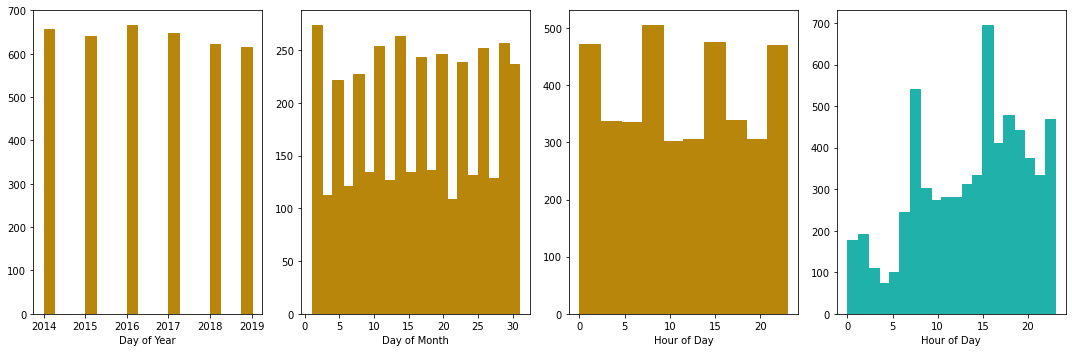

In [238]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
figure, ax = plt.subplots(1, 4, sharey=False, tight_layout=True, figsize=(15,5))

# We can set the number of bins with the `bins` kwarg
ax[0].hist(robbery_model_data_final_p['dyear'], bins=20, color = "darkgoldenrod", ec="darkgoldenrod")
ax[1].hist(robbery_model_data_final_p['dday'], bins=20, color = "darkgoldenrod", ec="darkgoldenrod")
ax[2].hist(robbery_model_data_final_p['dhour'], color = "darkgoldenrod", ec="darkgoldenrod")
ax[3].hist(pedestrian_model_data_final_p['HOUR'], bins=20, color = "lightseagreen", ec="lightseagreen")

ax[0].set_xlabel('Day of Year')
ax[1].set_xlabel('Day of Month')
ax[2].set_xlabel('Hour of Day')
ax[3].set_xlabel('Hour of Day')

save_results_to = 'C:/Users/jodyn/PycharmProjects/InsightFDS/notebooks/figures/'
plt.savefig(save_results_to + 'Date-Histogram.png', dpi = 300)

C:\Users\jodyn\anaconda3\envs\OSMNX\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


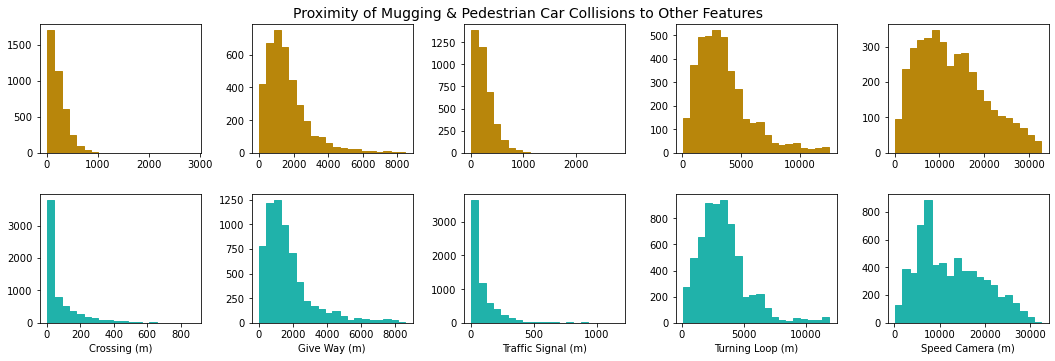

In [239]:
figure, ((axs1,axs2,axs3,axs4,axs5),(axs6,axs7,axs8,axs9,axs10)) = plt.subplots(2, 5, sharey=False, tight_layout=True,
                                                                                figsize=(15,5))

figure.tight_layout()
figure.tight_layout(pad=2.0)

figure.get_axes()[0].annotate('Proximity of Mugging & Pedestrian Car Collisions to Other Features', (0.5, 0.95), 
                            xycoords='figure fraction', ha='center', 
                            fontsize=14
                            )

# We can set the number of bins with the `bins` kwarg
axs1.hist(robbery_model_data_final_p['crossing'], bins=20, color = "darkgoldenrod", ec="darkgoldenrod")
axs2.hist(robbery_model_data_final_p['give_way'], bins=20, color = "darkgoldenrod", ec="darkgoldenrod")
axs3.hist(robbery_model_data_final_p['traffic_si'], bins=20, color = "darkgoldenrod", ec="darkgoldenrod")
axs4.hist(robbery_model_data_final_p['turning_lo'], bins=20, color = "darkgoldenrod", ec="darkgoldenrod")
axs5.hist(robbery_model_data_final_p['speed_came'], bins=20, color = "darkgoldenrod", ec="darkgoldenrod")
axs6.hist(pedestrian_model_data_final_p['crossing'], bins=20, color = "lightseagreen", ec="lightseagreen")
axs7.hist(pedestrian_model_data_final_p['give_way'], bins=20, color = "lightseagreen", ec="lightseagreen")
axs8.hist(pedestrian_model_data_final_p['traffic_si'], bins=20, color = "lightseagreen", ec="lightseagreen")
axs9.hist(pedestrian_model_data_final_p['turning_lo'], bins=20, color = "lightseagreen", ec="lightseagreen")
axs10.hist(pedestrian_model_data_final_p['speed_came'], bins=20, color = "lightseagreen", ec="lightseagreen")

axs6.set_xlabel('Crossing (m)')
axs7.set_xlabel('Give Way (m)')
axs8.set_xlabel('Traffic Signal (m)')
axs9.set_xlabel('Turning Loop (m)')
axs10.set_xlabel('Speed Camera (m)')

save_results_to = 'C:/Users/jodyn/PycharmProjects/InsightFDS/notebooks/figures/'
plt.savefig(save_results_to + 'Proximity-Histogram.png', dpi = 300)

Adding some psedo data based on the ranges of what are in the occurrences

In [242]:
print(robbery_model_data_final.isnull().sum())

OBJECTID      0
turning_lo    0
dyear         0
dday          0
dhour         0
Presence_A    0
crossing      0
give_way      0
speed_came    0
stop          0
traffic_si    0
Police_Div    0
NHood_ID      0
geometry      0
Latitude      0
Longitude     0
Hood_ID       0
dtype: int64


In [243]:
list(robbery_model_data_final.iloc[:,numpy.r_[5,2:5,1,6:12,16,13:16]])

['Presence_A',
 'dyear',
 'dday',
 'dhour',
 'turning_lo',
 'crossing',
 'give_way',
 'speed_came',
 'stop',
 'traffic_si',
 'Police_Div',
 'Hood_ID',
 'geometry',
 'Latitude',
 'Longitude']

**Pedestrian**: I will drop visibility, first, then I will make dummy variables.
**Robbery**: I wil drop the proximity features.

In [245]:
# need some dummy variables for my categorical data
# One-hot encode the data using pandas get_dummies
robbery_model_data_dummies = pandas.get_dummies(pedestrian_model_data_final_arcmap)
pedestrian_model_data_dummies = pandas.get_dummies(robbery_model_data_final_arcmap)

# do I need to balance data?
robbery_model_data_dummies.Presence_A.value_counts()

1.0    6433
0.0    6433
Name: Presence_A, dtype: int64

In [220]:
pedestrian_model_data_dummies.Presence_A.value_counts()

0.0    5141
1.0    5141
Name: Presence_A, dtype: int64

# Saving Data for Predicting Probabilties

In [247]:
import pickle
robbery_model_data_dummies.to_pickle("C:/Users/jodyn/Google Drive/Insight Data Science/Insight/Processed Data/robbery_model_data_dummies_bal.pkl")
pedestrian_model_data_dummies.to_pickle("C:/Users/jodyn/Google Drive/Insight Data Science/Insight/Processed Data/pedestrian_model_data_dummies_bal.pkl")